# A CNN to predict if someone is smiling

If you haven't looked yet, please refer to the model concerning attractiveness.

The sole purpose of this model is to illustrate the subjectivity of attributes. Here we have taken a most objective attribute: the smile. We are going to train exactly the same model as the attractiveness one, but this time to detect a smile. **We will see that this model performs much better because it is not subjective.**

*We have slightly less detailed the steps than in the other model. To better understand the steps, please refer to the template on the attractiveness.*

## 1. Global setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
MAIN_PATH = 'input/celeba_dataset/'
DATA_PATH = MAIN_PATH + 'img_align_celeba/img_align_celeba/'
ATTRIBUTE_PATH = MAIN_PATH + 'list_attr_celeba.csv'
TEST_PIC_PATH = './test_pic/'

SMILING_PATH = 'input/smiling/'

In [15]:
dataset = pd.read_csv(ATTRIBUTE_PATH, index_col='image_id')

## 2. Data pre-processing

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size = 0.2, random_state = 0)

In [17]:
import os

# Create our 2 directories
os.makedirs(SMILING_PATH + "train_set")
os.makedirs(SMILING_PATH + "test_set")

# Create subdirectories in each one
os.makedirs(SMILING_PATH + "test_set/not_smiling")
os.makedirs(SMILING_PATH + "test_set/smiling")
os.makedirs(SMILING_PATH + "train_set/smiling")
os.makedirs(SMILING_PATH + "train_set/not_smiling")

In [18]:

train_set_not_smiling = train_set.query('Smiling == -1')
train_set_smiling = train_set.query('Smiling == +1')

test_set_not_smiling = test_set.query('Smiling == -1')
test_set_smiling = test_set.query('Smiling == +1')

In [19]:
import shutil

for img in train_set_not_smiling.index.values:
  shutil.copy(DATA_PATH + img, SMILING_PATH + "train_set/not_smiling")
for img in train_set_smiling.index.values:
  shutil.copy(DATA_PATH + img, SMILING_PATH + "train_set/smiling")
  
for img in test_set_not_smiling.index.values:
  shutil.copy(DATA_PATH + img, SMILING_PATH + "test_set/not_smiling")
for img in test_set_smiling.index.values:
  shutil.copy(DATA_PATH + img, SMILING_PATH + "test_set/smiling")

## 3. Data Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

## 4. Building CNN

In [21]:
TARGET_SIZE = (64, 64)
BATCH_SIZE = 128

In [22]:
train_generator = train_datagen.flow_from_directory(
    SMILING_PATH + 'train_set',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

Found 162079 images belonging to 2 classes.


In [23]:
validation_generator = test_datagen.flow_from_directory(
    SMILING_PATH + 'test_set',
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

Found 40520 images belonging to 2 classes.


In [24]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

classifier = Sequential()
classifier.add(Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Conv2D(32,kernel_size=(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(units= 128, activation='relu'))
classifier.add(Dense(units= 1, activation='sigmoid'))

In [25]:
classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [27]:
history = classifier.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 12,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

Epoch 1/12
1266/1266 [==============================] - 182s 143ms/step - loss: 0.1996 - accuracy: 0.9162 - val_loss: 0.1970 - val_accuracy: 0.9175
Epoch 2/12
1266/1266 [==============================] - 181s 143ms/step - loss: 0.1986 - accuracy: 0.9167 - val_loss: 0.1950 - val_accuracy: 0.9190
Epoch 3/12
1266/1266 [==============================] - 181s 143ms/step - loss: 0.1977 - accuracy: 0.9170 - val_loss: 0.1989 - val_accuracy: 0.9153
Epoch 4/12
1266/1266 [==============================] - 185s 146ms/step - loss: 0.1977 - accuracy: 0.9171 - val_loss: 0.1979 - val_accuracy: 0.9168
Epoch 5/12
1266/1266 [==============================] - 182s 144ms/step - loss: 0.1953 - accuracy: 0.9182 - val_loss: 0.1994 - val_accuracy: 0.9158
Epoch 6/12
1266/1266 [==============================] - 181s 143ms/step - loss: 0.1952 - accuracy: 0.9186 - val_loss: 0.1964 - val_accuracy: 0.9170
Epoch 7/12
1266/1266 [==============================] - 182s 144ms/step - loss: 0.1946 - accuracy: 0.9181 - val_

Save the classifier at the root of our repository to use it later (without the need to re-compile the classifier).

In [28]:
classifier.save('./exported_model/smiling_model.h5')

## 5. Evaluate the model

Load our already trained model.

In [2]:
from keras.models import load_model

classifier= load_model('./exported_model/smiling_model.h5')

As we can see, in the early stages, the model performs much better than the attractiveness model. We get almost 10 more accuracy points and a loss of less than 15 points.

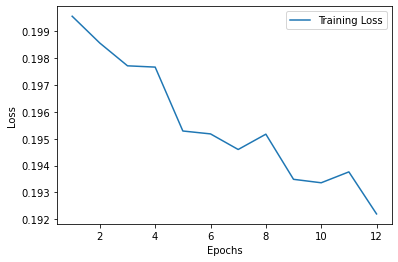

In [30]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Our model, obtain much better results thant the attractiveness one.

In [31]:
results = classifier.evaluate(validation_generator, verbose=0)
results

[0.19451741874217987, 0.9190523624420166]

We can summarize the performance of our classification model using a confusion matrix.

In [32]:
predictions = classifier.predict(validation_generator)
predictions = (predictions > 0.5)

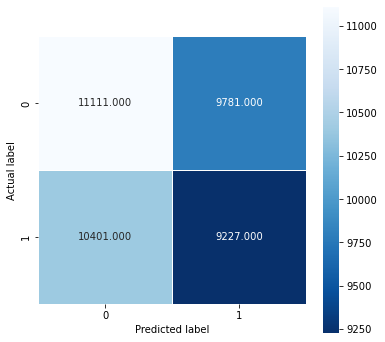

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(validation_generator.classes, predictions)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

## 6. Predict a single image

In [3]:
from keras_preprocessing import image

def classify(imagePath):
  test_image = image.load_img(imagePath, target_size = (64, 64))
  test_image = image.img_to_array(test_image).astype('float32') / 255 
  test_image = np.expand_dims(test_image, axis = 0) # add an extra dimension to fake batch

  result = classifier.predict(test_image)
  if result[0][0] >= 0.5:
      prediction = 'smiling'
      probability = result[0][0]
  else:
      prediction = 'not smiling'
      probability = 1 - result[0][0]
  print("This person is " + prediction + " (" + str(probability * 100) + "%).")

In [4]:
from keras.preprocessing.image import load_img

def showImage(imagePath):
  img = load_img(imagePath)
  plt.imshow(img)
  plt.show()

This person is not smiling (95.36238722503185%).


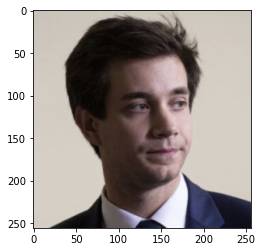

In [11]:
imageToClassify = TEST_PIC_PATH + "0.jpg" # Can test from 0 to 3
classify(imageToClassify)
showImage(imageToClassify)

We obtain much better result than attractiveness model. Our images are well classified.

## Conclusion

This model perfectly illustrates the subjectivity factor of attributes. The same model will perform much better with an objective attribute like smile, age or gender. On the other hand, subjective attributes, such as attractiveness, require much more training. And even after, they will always perform worse. 

On top of that, since the dataset completely influences the model, it can very quickly appear biased depending on the context. For example, if our dataset is not well balanced and presents one skin color more than another, the model will very quickly show its limits on the least represented skin color.

You can check this model running [here](https://smile-ai.vercel.app).